In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 924949705168642126,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9984750400
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18119264945144858392
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:1d:00.0, compute capability: 6.1"]

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import SimpleITK as sitk 
from tqdm import tqdm
import numpy as np
%pylab inline

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans

from tensorflow.keras.utils import to_categorical,normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D,add,Input,Dropout,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda,PReLU,concatenate,Lambda
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Nadam
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.initializers as initializers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
for dirname, _, filenames in os.walk("C:/NewDataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_flair.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_seg.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t1.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t2.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_flair.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_seg.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t1.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t1ce.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t2.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_flair.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_seg.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t1.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t2.nii
C:/NewDataset\BraTS20_Training_004\Br

In [4]:
path = "C:/NewDataset/"

In [5]:
def load_data(path):
    my_dir = sorted(os.listdir(path))
    data = []
    gt = []
    for p in tqdm(my_dir):
        data_list = sorted(os.listdir(path+p))
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
        flair = sitk.GetArrayFromImage(img_itk)
        flair = flair[30:120,30:222,30:222].reshape([-1,192,192])
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
        seg =  sitk.GetArrayFromImage(img_itk)
        seg = seg[30:120,30:222,30:222].reshape([-1,192,192])
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])
        t1 =  sitk.GetArrayFromImage(img_itk)
        t1 = t1[30:120,30:222,30:222].reshape([-1,192,192])
        

        img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
        t1ce =  sitk.GetArrayFromImage(img_itk)
        t1ce = t1ce[30:120,30:222,30:222].reshape([-1,192,192])

        img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
        t2 =  sitk.GetArrayFromImage(img_itk)
        
        t2 = t2[30:120,30:222,30:222].reshape([-1,192,192])

        data.append([flair,t1,t1ce,t2])
        gt.append(seg)
    data = np.asarray(data,dtype=np.float32)
    gt = np.asarray(gt,dtype=np.uint8)
    return data,gt

In [6]:
#HGG
data,gt = load_data(path)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


In [7]:
data.shape

(100, 4, 90, 192, 192)

In [8]:
gt.shape

(100, 90, 192, 192)

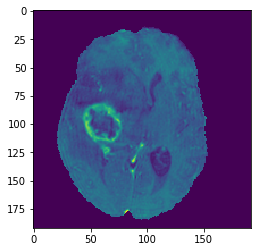

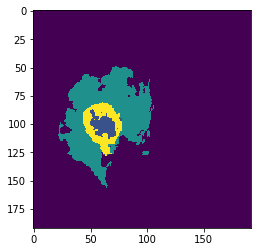

In [9]:
plt.imshow(data[0,2,42,:,:])
plt.show()
plt.imshow(gt[0,42,:,:])
plt.show()

In [10]:
data = np.transpose(data,(0,2,3,4,1))

In [11]:
data.shape,gt.shape,data.dtype,gt.dtype

((100, 90, 192, 192, 4), (100, 90, 192, 192), dtype('float32'), dtype('uint8'))

In [12]:
data = data.reshape([-1,192,192,4])
gt = gt.reshape([-1,192,192,1])

In [13]:
data.shape,gt.shape,data.dtype,gt.dtype

((9000, 192, 192, 4), (9000, 192, 192, 1), dtype('float32'), dtype('uint8'))

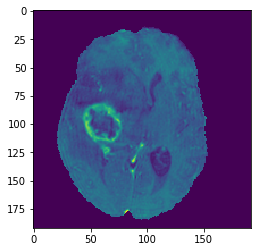

In [20]:
plt.imshow(data[42,:,:,2])
plt.show()
#plt.imshow(gt[42,:,:,])
#plt.show()

In [21]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42) 

In [23]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [24]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((5400, 192, 192, 4),
 (5400, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 1))

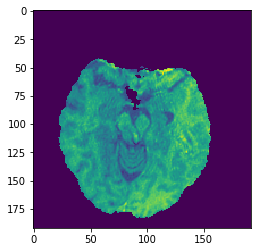

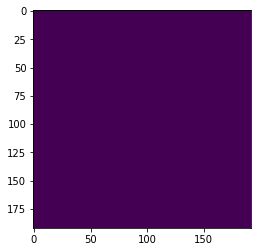

In [25]:
plt.imshow(X_train[0,:,:,1])
plt.show()
plt.imshow(Y_train[0,:,:,1])
plt.show()

In [26]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((5400, 192, 192, 4),
 (5400, 192, 192, 4),
 (1800, 192, 192, 4),
 (1800, 192, 192, 4))

In [27]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
  

## 2DV_NET MODEL

In [28]:
def resBlock(conv,stage,keep_prob,stage_num=5):
    inputs=conv
    
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([inputs,conv]))
    conv_drop=Dropout(keep_prob)(conv_add)
    
    if stage<stage_num:
        conv_downsample=PReLU()(BatchNormalization()(Conv2D(16*(2**stage), 2, strides=(2, 2),activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv_drop)))
        return conv_downsample,conv_add
    else:
        return conv_add,conv_add
        
def up_resBlock(forward_conv,input_conv,stage):
    conv=concatenate([forward_conv,input_conv],axis = -1)
  
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([input_conv,conv]))
    if stage>1:
        conv_upsample=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(stage-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

def vnet(pretrained_weights = None,input_size = (192,192,4),num_class=1,is_training=True,stage_num=5,thresh=0.5):
    keep_prob = 0.1
    features=[]
    input_model = Input(input_size)
    x=PReLU()(BatchNormalization()(Conv2D(16, 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(input_model)))
    
    for s in range(1,stage_num+1):
        x,feature=resBlock(x,s,keep_prob,stage_num)
        features.append(feature)
        
    conv_up=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(s-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(x)))
    
    for d in range(stage_num-1,0,-1):
        conv_up=up_resBlock(features[d-1],conv_up,d)
    if num_class>1:
        conv_out=Conv2D(num_class, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    else:
        conv_out=Conv2D(num_class, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    
    
    
    
    model=Model(inputs=input_model,outputs=conv_out)    

    model.compile(optimizer = Nadam(lr = 2e-4),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model
model=vnet(input_size = (192,192,4),num_class=4,stage_num=5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 192, 192, 16) 589824      batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
checkpointer = callbacks.ModelCheckpoint(filepath = 'vnet-weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [30]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=16,epochs=30,callbacks=[checkpointer],shuffle=True)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

338/338 [==============================] - 87s 257ms/step - loss: 0.0027 - dice_coef: 0.9973 - accuracy: 0.9969 - val_loss: 0.0034 - val_dice_coef: 0.9966 - val_accuracy: 0.9962
Epoch 26/30
338/338 [==============================] - 98s 290ms/step - loss: 0.0027 - dice_coef: 0.9973 - accuracy: 0.9970 - val_loss: 0.0034 - val_dice_coef: 0.9966 - val_accuracy: 0.9962
Epoch 27/30
338/338 [==============================] - 99s 292ms/step - loss: 0.0027 - dice_coef: 0.9973 - accuracy: 0.9969 - val_loss: 0.0032 - val_dice_coef: 0.9968 - val_accuracy: 0.9965
Epoch 28/30
338/338 [==============================] - 93s 275ms/step - loss: 0.0026 - dice_coef: 0.9974 - accuracy: 0.9971 - val_loss: 0.0031 - val_dice_coef: 0.9969 - val_accuracy: 0.9965
Epoch 29/30
338/338 [==============================] - 95s 282ms/step - loss: 0.0026 - dice_coef: 0.9974 - accuracy: 0.9971 - val_loss: 0.0031 - val_dice_coef: 0.9969 - val_accuracy: 0.9965
Epoch 30/30
338/338 [==============================] - 97s 286

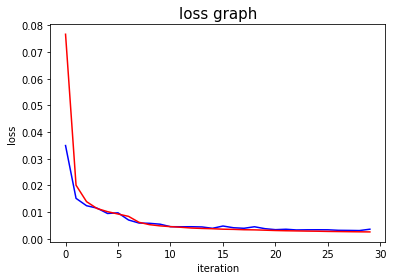

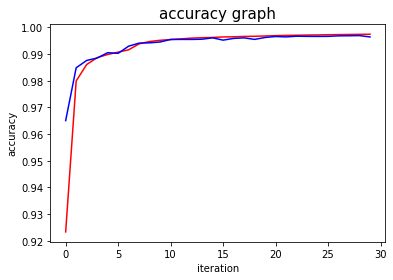

In [31]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.savefig("2DV_NET_history-loss.png")
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.savefig("2DV_NET_history-acc.png")
plt.show()

In [32]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [33]:
np.unique(Y_pre)

array([0, 1, 2, 3], dtype=int64)

In [34]:
Y_pre.shape

(1800, 192, 192)

In [35]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [36]:
Y_test.shape,X_test.shape

((1800, 192, 192, 1), (1800, 192, 192, 4))

X_test 0


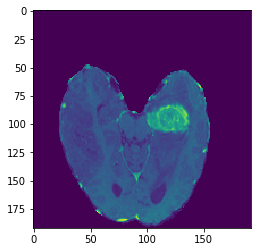

Predicted 0


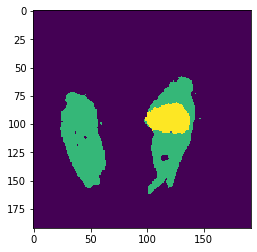

Actual 0


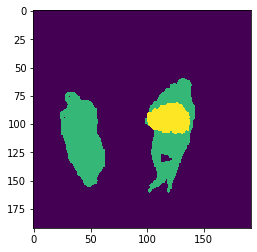

X_test 1


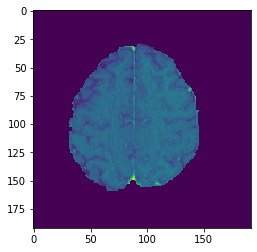

Predicted 1


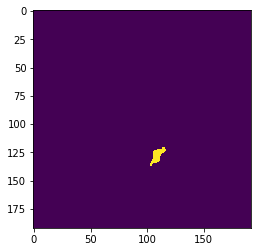

Actual 1


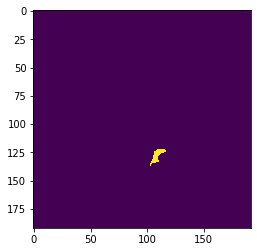

X_test 2


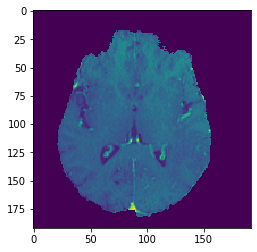

Predicted 2


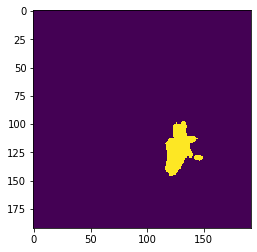

Actual 2


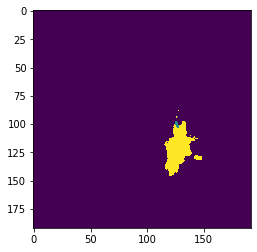

X_test 3


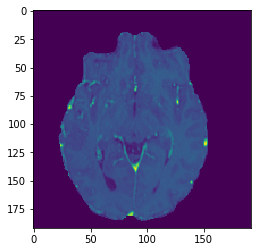

Predicted 3


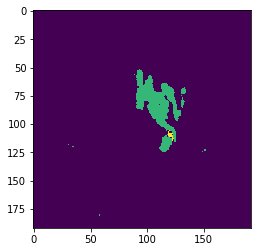

Actual 3


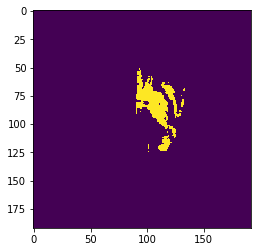

X_test 4


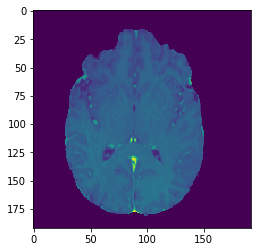

Predicted 4


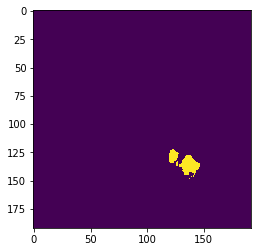

Actual 4


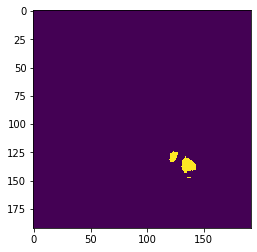

X_test 5


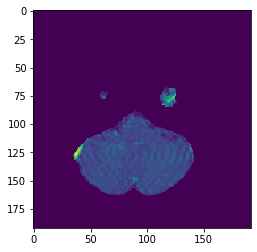

Predicted 5


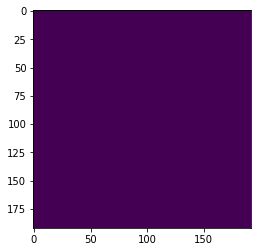

Actual 5


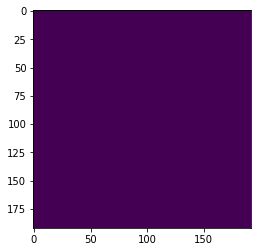

X_test 6


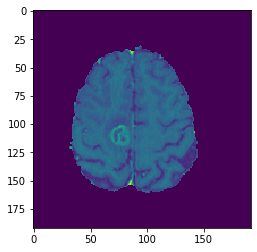

Predicted 6


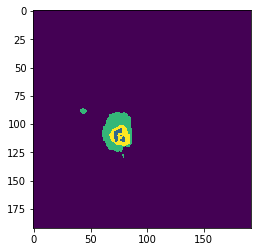

Actual 6


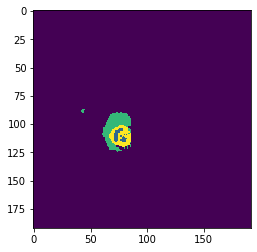

X_test 7


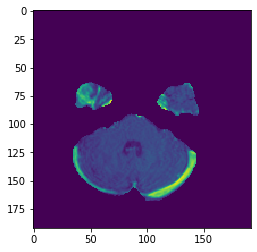

Predicted 7


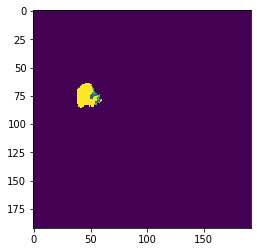

Actual 7


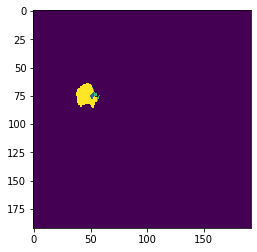

X_test 8


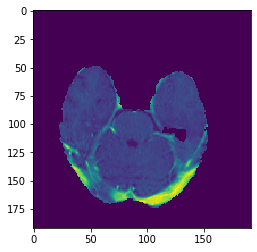

Predicted 8


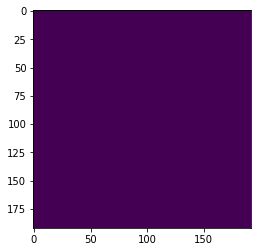

Actual 8


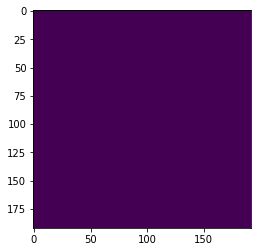

X_test 9


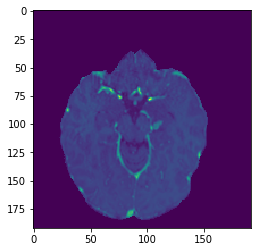

Predicted 9


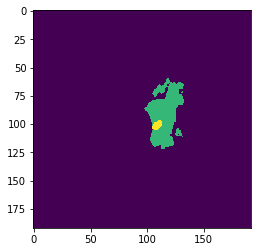

Actual 9


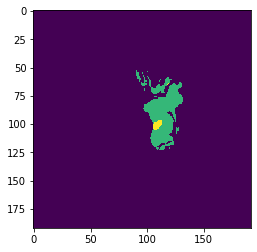

X_test 10


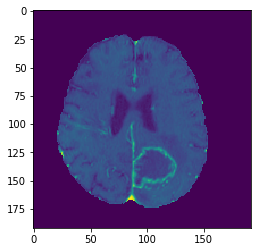

Predicted 10


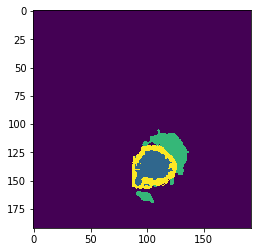

Actual 10


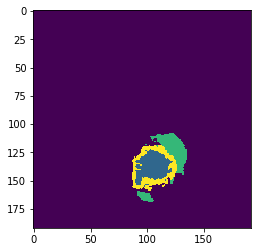

X_test 11


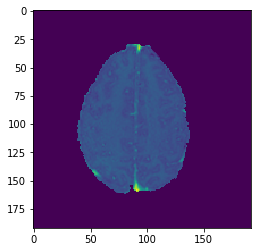

Predicted 11


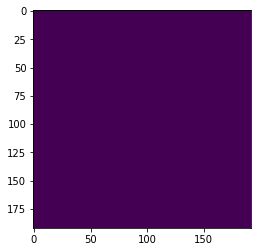

Actual 11


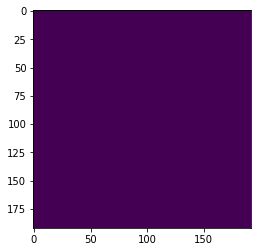

X_test 12


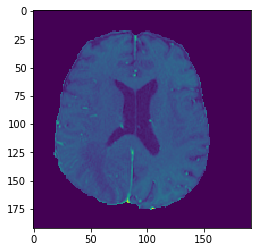

Predicted 12


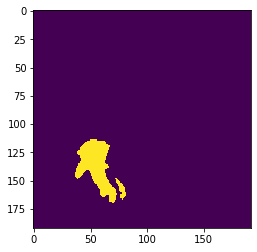

Actual 12


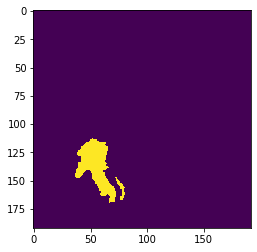

X_test 13


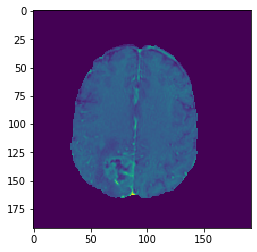

Predicted 13


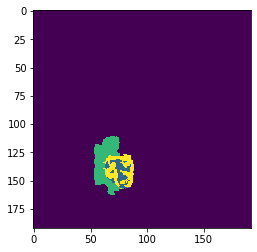

Actual 13


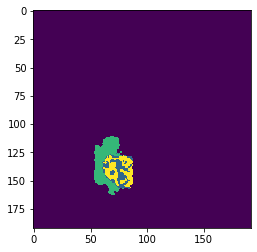

X_test 14


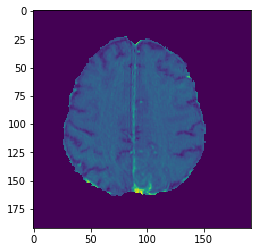

Predicted 14


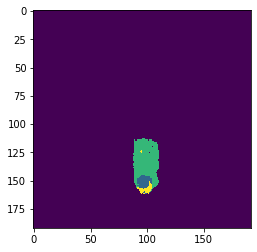

Actual 14


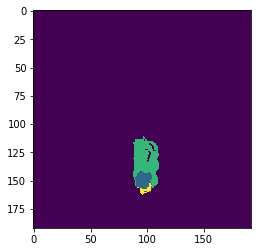

X_test 15


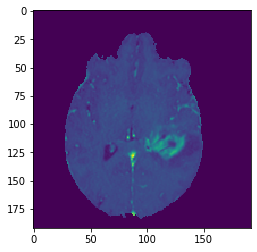

Predicted 15


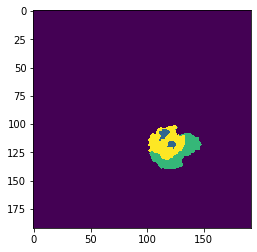

Actual 15


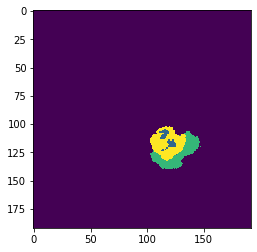

X_test 16


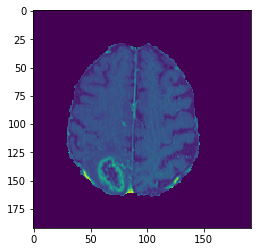

Predicted 16


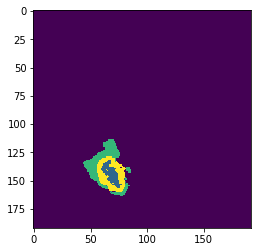

Actual 16


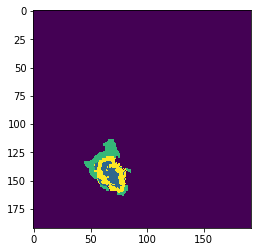

X_test 17


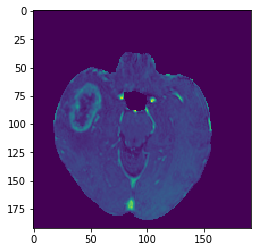

Predicted 17


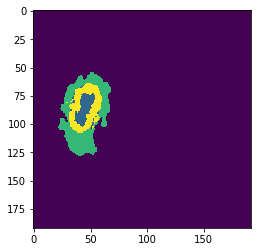

Actual 17


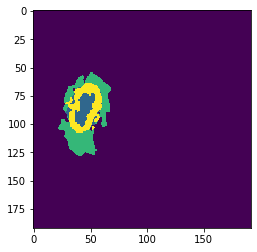

X_test 18


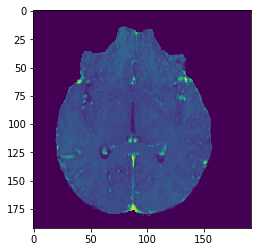

Predicted 18


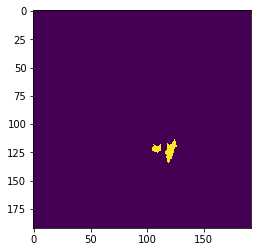

Actual 18


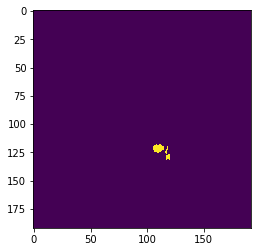

X_test 19


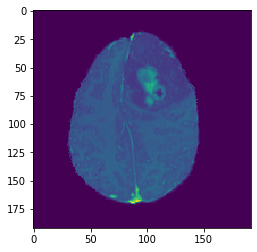

Predicted 19


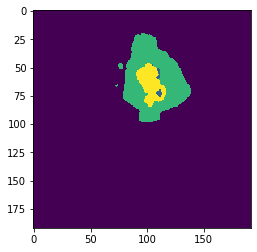

Actual 19


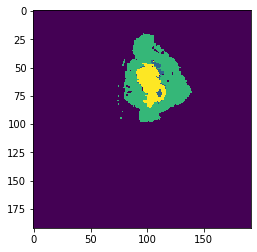

In [37]:
for i in range(20):
    print('X_test '+ str(i))
    plt.imshow(X_test[i,:,:,2])
    plt.show()

    print('Predicted '+ str(i))
    plt.imshow(Y_pre[i,:,:,0])
    plt.show()

    print('Actual '+ str(i))
    plt.imshow(Y_test[i,:,:,0])
    plt.show()

In [38]:
Y_test_encod = to_categorical(Y_test)

In [39]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

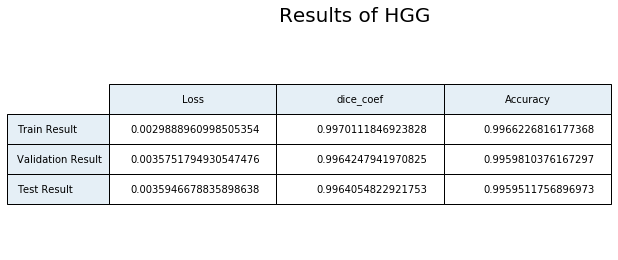

In [40]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.savefig("2DV_NET_result-table.png", bbox_inches="tight")

## END